# Regresja oparta o modele drzewiaste

## Wstęp

Wraz z rozwojem uczenia maszynowego powstały coraz bardziej złożone algorytmy. Przy wykorzystaniu większej liczby zmiennych oraz większego wolumenu danych osiągają one lepsze wyniki. Takimi algorytmami są między innymi XGBoost oraz LightGBM. Są to modele drzewiaste, których zrozumienie rozpoczyna się wraz ze zrozumieniem modelu drzew decyzyjnych. Poniższy notatnik opiera się na wprowadzeniu w świat tych właśnie algorytmów. 

***
W poniższej części zostaną przedstawione 4 następujące algorytmy regresyjne:

- Decision Trees
- Random Forest
- XGBoost
- LightGBM

In [2]:
# Data processing
import numpy as np
import pandas as pd

# Wizualizacja
from matplotlib import pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm
import xgboost

### Przygotowanie danych

Na potrzebę budowy modeli drzewiastych zostaną wprowadzone poniższe losowo wygenerowane dane treningowe:

In [3]:
N = 125
np.random.seed(23)
x = np.random.rand(N,1) * 2 - 1
noise = np.random.normal(0,0.2,size=(N,1))
y = x ** 2 + 0.5 * np.sin(x) + noise

x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state = 11, test_size = 0.2)

Ponadto w celach edukacyjnych ponownie wytrenujemy model regresji wielomianowej, aby następnie porównać skuteczność modeli drzewiastych do modelu wielomianowego.

In [4]:
# Polynomial features
poly = PolynomialFeatures(degree = 2)
x_train_poly = poly.fit_transform(x_train)
x_valid_poly = poly.transform(x_valid)

# Model fit
model = LinearRegression(positive=False, fit_intercept=True)    
model.fit(x_train_poly,y_train)

# Predict
preds_poly = model.predict(x_valid_poly)

## Decision Trees

Drzewa decyzyjne to algorytm modelujący dane nieliniowo, nadający się zarówno do klasyfikacji, jak i regresji. Przyjmują one dowolne typy danych, numeryczne i kategoryczne, bez założeń dotyczących rozkładu i bez potrzeby ich wstępnego przetwarzania. Algorytm ten jest względnie łatwy w użyciu, a jego wyniki są w miarę proste w interpretacji. Po dopasowaniu modelu, przewidywanie wyników jest szybkim procesem. Jednak drzewa decyzyjne mają też swoje wady, mają one tendencję do przeuczania (zwłaszcza, gdy nie są przycinane).

**Konstrukcja**

Drzewa decyzyjnie można podsumować jako serię pytań/warunków dla ustalonego rekordu w danych treningowych, które kończą się zwróceniem przez drzewo informacji o oczekiwanej wartości (klasie) zmiennej objaśnianej dla owego rekordu. Składają się one z węzłów, gałęzi i liści. Konstrukcję zaczyna się od korzenia, czyli pierwszego węzła. Następnie tworzymy gałęzie odpowiadające różnym odpowiedziom na to pytanie, i powtarzamy te czynności do momentu, gdy drzewo zwraca nam oczekiwaną wartość zmiennej objaśnianej. Jeśli w liściu znalazła się więcej niż jedna wartość, wyznaczamy średnią z owych wartości jako wskazaną przez drzewo. Drzewa stosowane w regresji nazywa się czasem drzewami regresyjnymi.

**Przycinanie liści**

Żeby zapobiec zbyt dużemu rozrostowi drzewa decyzyjnego, który może doprowadzić do małego poziomu generalizacji oraz spowolnienia działania algorytmu, stosuje się tak zwane przycianie drzewa (ang pruning). Polega ono na usuwaniu zbędnych elementów z drzewa po jego utworzeniu. Wyróżnia się dwa podstawowe rodzaje przycinania:

1) przycinanie wsteczne, polegające na wygenerowaniu drzewa, które jest bardzo dobrze dopasowane do zbioru treningowego, a następnie usuwanie od dołu najmniej efektywnych węzłów,

2) przycinanie w przód, polegające na wstrzymaniu dalszej rozbudowy danej gałęzi jeśli na węźle znajduje się ilość próbek zaklasyfikowanych do danej klasy, przekracza wyznaczony próg.

**Miary wyboru podziału drzewa regresyjnego**

W drzewach decyzyjnych dla klasyfikacji, drzewo musi zadawać właściwe pytania we właściwym momencie, aby dokładnie klasyfikować dane. W tym celu korzysta się z miar entropii, przyrostu informacji lub indeksu Giniego. Jednak ponieważ teraz przewidujemy wartości ciągłych zmiennych, potrzebujemy innej miary. Takiej, która określa odchylenie predykcji od rzeczywistej wartości. Naturalnym wyborem w regresji zdaje się być błąd średniokwadratowy, dany dla przypomnienia wzorem 

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y})^2,$$

gdzie $Y$ to wartości znajdujące się w węźle drzewa, który chcemy dzielić, zaś $\hat{Y}$ jest ich średnią. Wybierając podział należy ten błąd zminimalizować. Alternatywnie korzysta się z następujących kryteriów: MSE Friedmana, MAE oraz Poisson deviance.

Przejdźmy przez przykładowy, ręczny wybór podziału.

In [5]:
df_example = pd.DataFrame({'X': list(range(1,15)), 'Y': [1,1.2,1.4,1.1,1,5.5,6.1,6.7,6.4,6,6,3,3.2,3.1]})
df_example


,X,Y
0,1,1.0
1,2,1.2
2,3,1.4
3,4,1.1
4,5,1.0
5,6,5.5
6,7,6.1
7,8,6.7
8,9,6.4
9,10,6.0


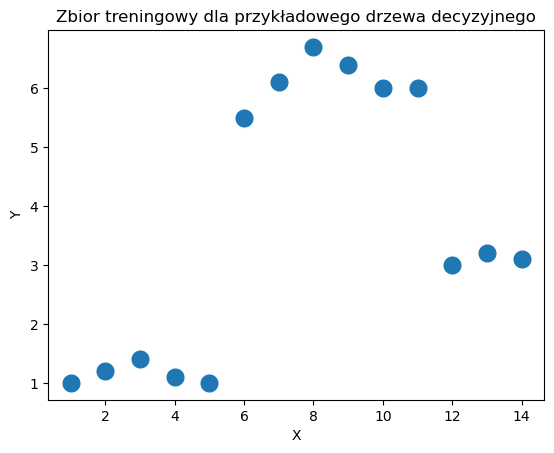

In [6]:
sns.scatterplot(x = df_example['X'], y = df_example['Y'], s = 200)
plt.title('Zbior treningowy dla przykładowego drzewa decyzyjnego')
plt.show()

Początkowa wartość $MSE$ wynosi

In [7]:
print('MSE =', (np.sum((df_example['Y'] - np.mean(df_example['Y'])) ** 2))/ df_example.shape[0])

MSE = 4.989234693877552


Dopiero zaczynamy budować drzewo, zatem w aktualnym węźle znajdują się wszystkie wartości $X$. Dla takiego zbioru danych, wszystkie możliwe warunki mają postać "Czy $X$ jest większe/mniejsze niż $a$?", gdzie $a$ to może być dowolna liczba z przedziału $(0,14)$. Dla uproszczenia będziemy rozpatrywać liczby $1.5,2.5,...,13.5$. Należy podzielić zbiór na każdy z 13 możliwych sposobów, wyznaczyć średnie wartości w węzłach jako aktualne wartości predykcji dla danego $X$, wyznaczyć wszystkie wartości $MSE$ oraz wybrać podział, dla którego ten błąd jest najmniejszy.

In [8]:
cut_list = []
mse_list = []

for i in range(1,14):
    
    cut = i + 0.5
    cut_list.append(cut)
    
    values_below = df_example[df_example['X'] < cut]
    values_above = df_example[df_example['X'] > cut]
    
    pred_below = np.mean(values_below['Y'])
    pred_above = np.mean(values_above['Y'])
    
    sse = sum((values_below['Y'] - pred_below) ** 2) + sum((values_above['Y'] - pred_above) ** 2)
    mse = sse / len(df_example)
    mse_list.append(mse)

In [9]:
df_tree_cut = pd.DataFrame({'cut': cut_list, 'mse': mse_list})
df_tree_cut

,cut,mse
0,1.5,4.431429
1,2.5,3.868750
2,3.5,3.294416
3,4.5,2.453393
4,5.5,1.368635
5,6.5,2.488006
6,7.5,3.497347
7,8.5,4.349167
8,9.5,4.810540
9,10.5,4.982250


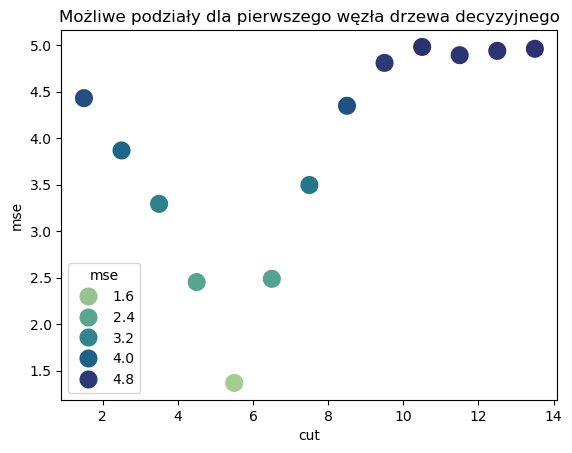

In [10]:
sns.scatterplot(x = df_tree_cut['cut'], y = df_tree_cut['mse'], s = 200, hue = df_tree_cut['mse'], palette = 'crest')
plt.title('Możliwe podziały dla pierwszego węzła drzewa decyzyjnego')
plt.show()

Stąd otrzymujemy, że pierwszy węzeł drzewa powinien zawierać warunek 

"Czy _X_ jest większe/mniejsze niż _5.5_?"

Stwórzmy teraz całe drzewo regresyjne na zbiorze danych, z którego korzystaliśmy przy okazji regresji wielomianowej. Tym razem już automatycznie. 

In [11]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train, y_train)
preds_dt = dt_reg.predict(x_valid)

In [12]:
wyniki6 = pd.DataFrame(data = {'RSS':[np.sum(np.square(preds_poly - y_valid)),
                                      np.sum(np.square(np.reshape(preds_dt, (25,1)) - y_valid))
                                    ],
                             'R2': [r2_score(y_valid, preds_poly),
                                    r2_score(y_valid, preds_dt)
                                    ],
                             'MAE': [mean_absolute_error(y_valid, preds_poly), 
                                     mean_absolute_error(y_valid, preds_dt)]}, 
                      index=['square_reg', 'dt_reg']).style.background_gradient(cmap='Blues')
wyniki6

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,1.442085,0.632443,0.197432


Wyniki modelu na zbiorze walidacyjnym nie są dobre. Zwizualizujmy stworzone drzewo żeby sprawdzić, co mogło pójść nie tak.

|--- feature_0 <= 0.56
|   |--- feature_0 <= -0.74
|   |   |--- feature_0 <= -0.79
|   |   |   |--- feature_0 <= -0.81
|   |   |   |   |--- feature_0 <= -0.86
|   |   |   |   |   |--- feature_0 <= -0.99
|   |   |   |   |   |   |--- feature_0 <= -1.00
|   |   |   |   |   |   |   |--- value: [0.22]
|   |   |   |   |   |   |--- feature_0 >  -1.00
|   |   |   |   |   |   |   |--- value: [0.36]
|   |   |   |   |   |--- feature_0 >  -0.99
|   |   |   |   |   |   |--- feature_0 <= -0.89
|   |   |   |   |   |   |   |--- feature_0 <= -0.99
|   |   |   |   |   |   |   |   |--- value: [0.49]
|   |   |   |   |   |   |   |--- feature_0 >  -0.99
|   |   |   |   |   |   |   |   |--- feature_0 <= -0.95
|   |   |   |   |   |   |   |   |   |--- value: [0.75]
|   |   |   |   |   |   |   |   |--- feature_0 >  -0.95
|   |   |   |   |   |   |   |   |   |--- value: [0.67]
|   |   |   |   |   |   |--- feature_0 >  -0.89
|   |   |   |   |   |   |   |--- value: [0.46]
|   |   |   |   |--- feature_0 >  -0.86
|  

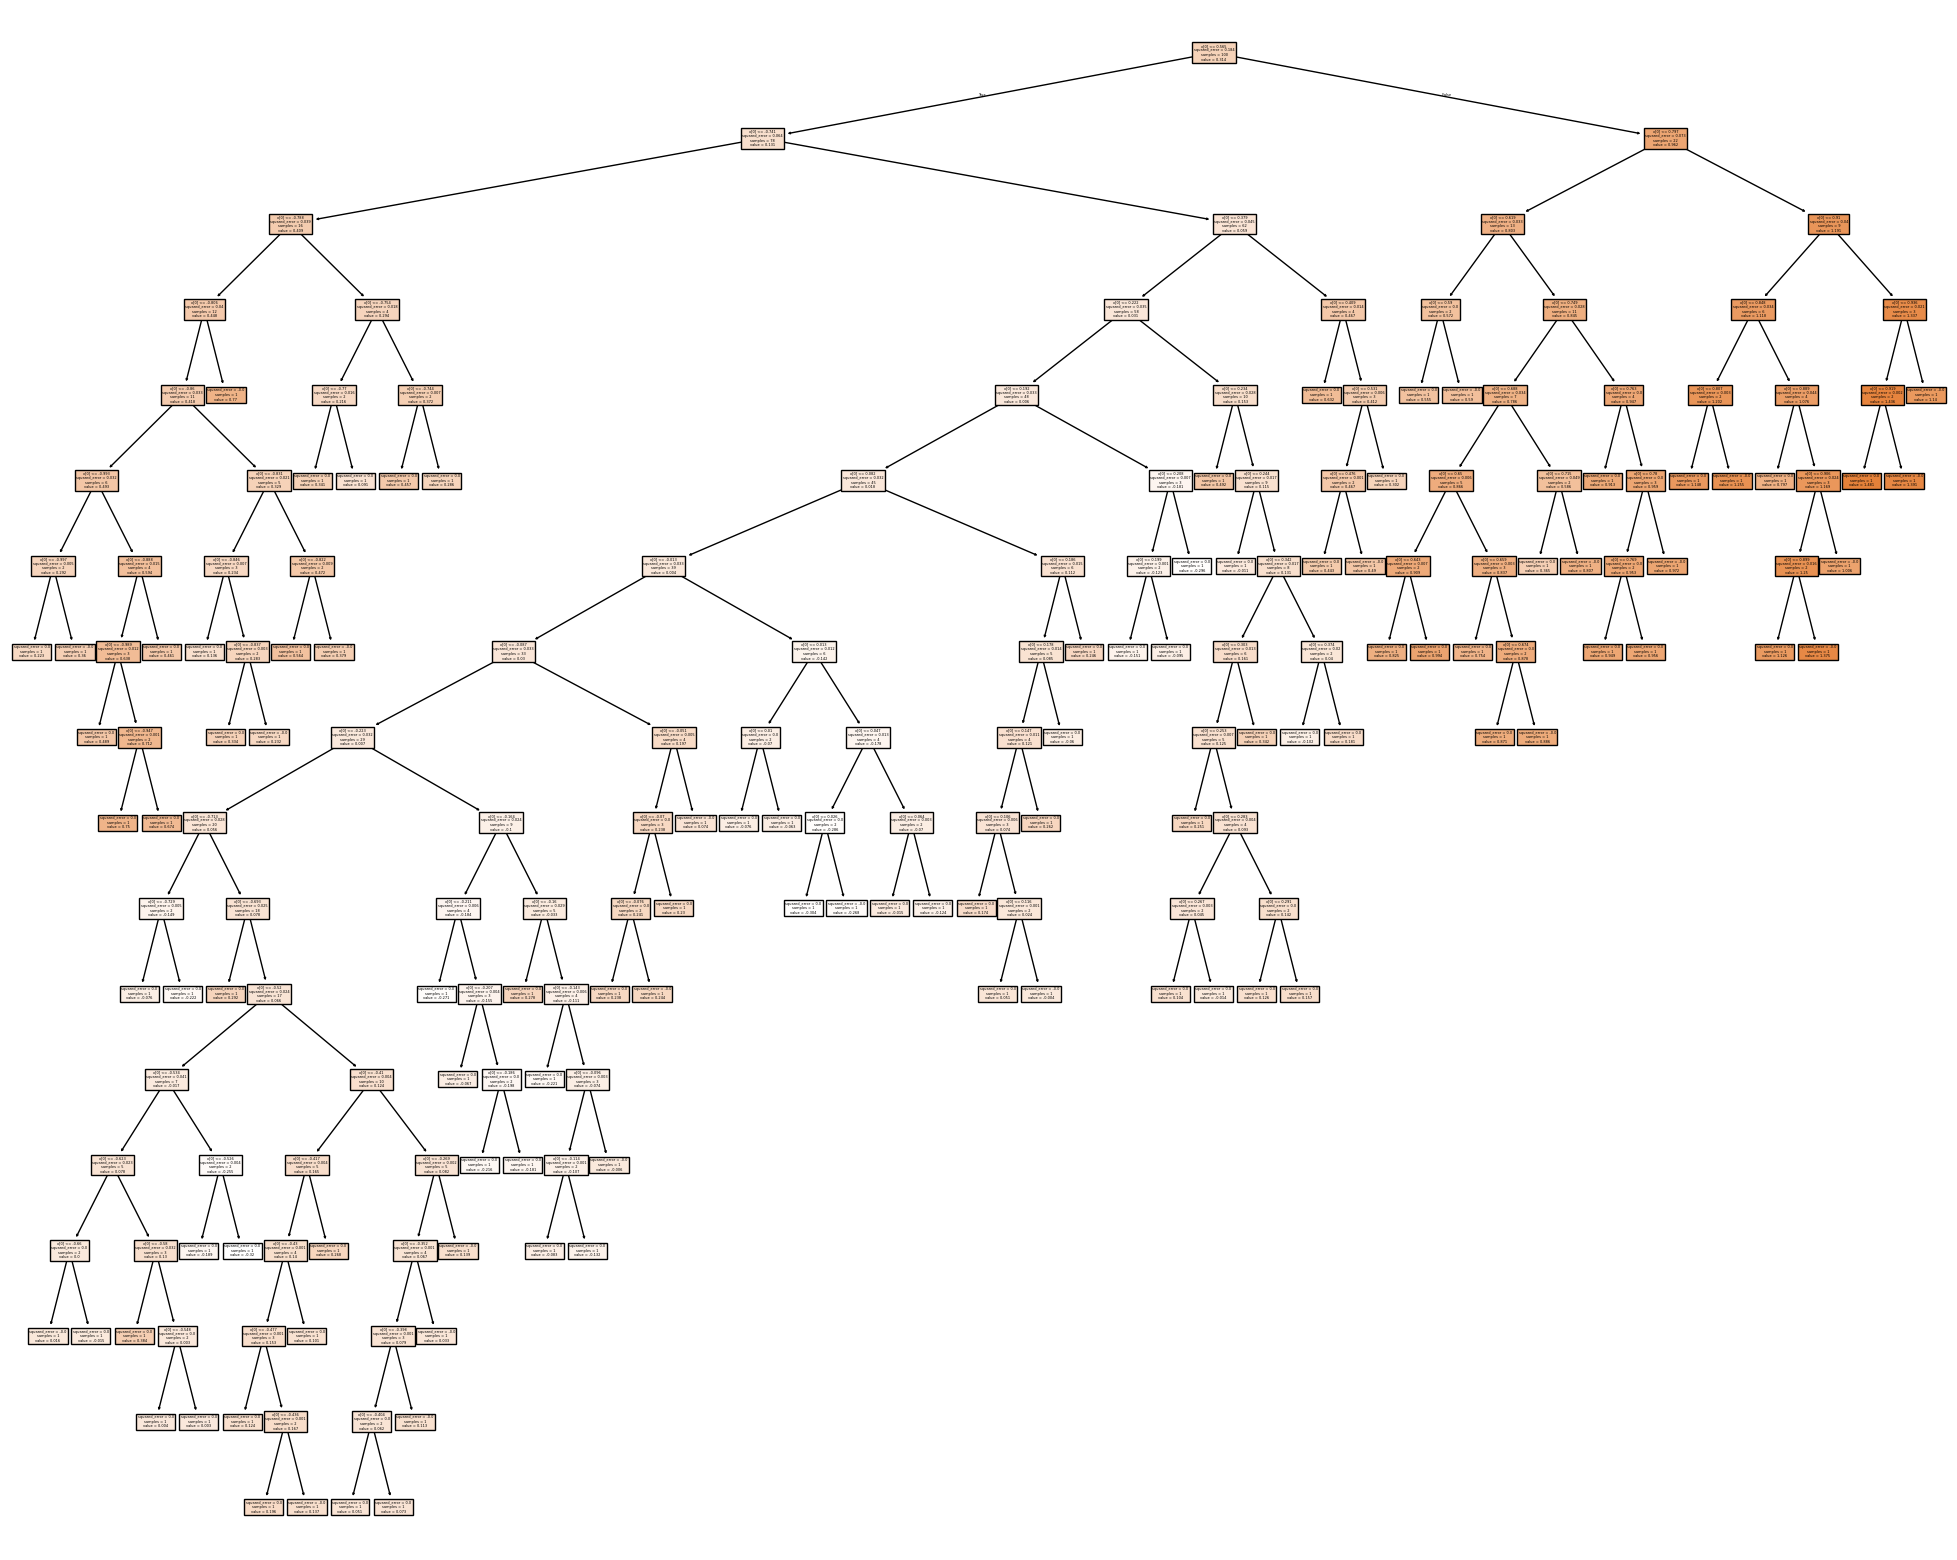

In [13]:
print(export_text(dt_reg))
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_reg, filled=True)

Wygląda na to, że domyślne drzewo regresyjne stworzyło tak dużo węzłów, że model jest mocno przeuczony. Aby temu zapobiec, ograniczymy głębokość drzewa, czyli maksymalną liczbę węzłów od korzenia do liścia włącznie.

In [14]:
dt_reg2 = DecisionTreeRegressor(max_depth = 3)
dt_reg2.fit(x_train, y_train)
preds_dt2 = dt_reg2.predict(x_valid)

In [15]:
wyniki7 = pd.DataFrame(
    data = 
        {
            'RSS':[np.sum(np.square(preds_poly - y_valid)),
                  np.sum(np.square(np.reshape(preds_dt2, (25,1)) - y_valid))
                ],
            'R2': [r2_score(y_valid, preds_poly),
                r2_score(y_valid, preds_dt2)
                ],
            'MAE': [mean_absolute_error(y_valid, preds_poly), 
                 mean_absolute_error(y_valid, preds_dt2)]
        }, 
    index=['square_reg', 'dt_reg']
).style.background_gradient(cmap='Blues')
wyniki7

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,0.574310,0.853621,0.126859


Ograniczenie głębokości drzewa pomogło i model jest teraz skuteczniejszy niż regresja kwadratowa. Przykładowe hiperparametry, które można regulować/optymalizować to: 

- criterion - kryterium wyboru podziału węzła,
- min_samples_split - minimalna liczba wartości do podzielenia węzła,
- min_samples_leaf - minimalna liczba wartości w liściu drzewa,
- max_depth - maksymalna głębokość drzewa.

|--- feature_0 <= 0.56
|   |--- feature_0 <= -0.74
|   |   |--- feature_0 <= -0.79
|   |   |   |--- value: [0.45]
|   |   |--- feature_0 >  -0.79
|   |   |   |--- value: [0.29]
|   |--- feature_0 >  -0.74
|   |   |--- feature_0 <= 0.38
|   |   |   |--- value: [0.03]
|   |   |--- feature_0 >  0.38
|   |   |   |--- value: [0.47]
|--- feature_0 >  0.56
|   |--- feature_0 <= 0.80
|   |   |--- feature_0 <= 0.62
|   |   |   |--- value: [0.57]
|   |   |--- feature_0 >  0.62
|   |   |   |--- value: [0.84]
|   |--- feature_0 >  0.80
|   |   |--- feature_0 <= 0.91
|   |   |   |--- value: [1.12]
|   |   |--- feature_0 >  0.91
|   |   |   |--- value: [1.34]



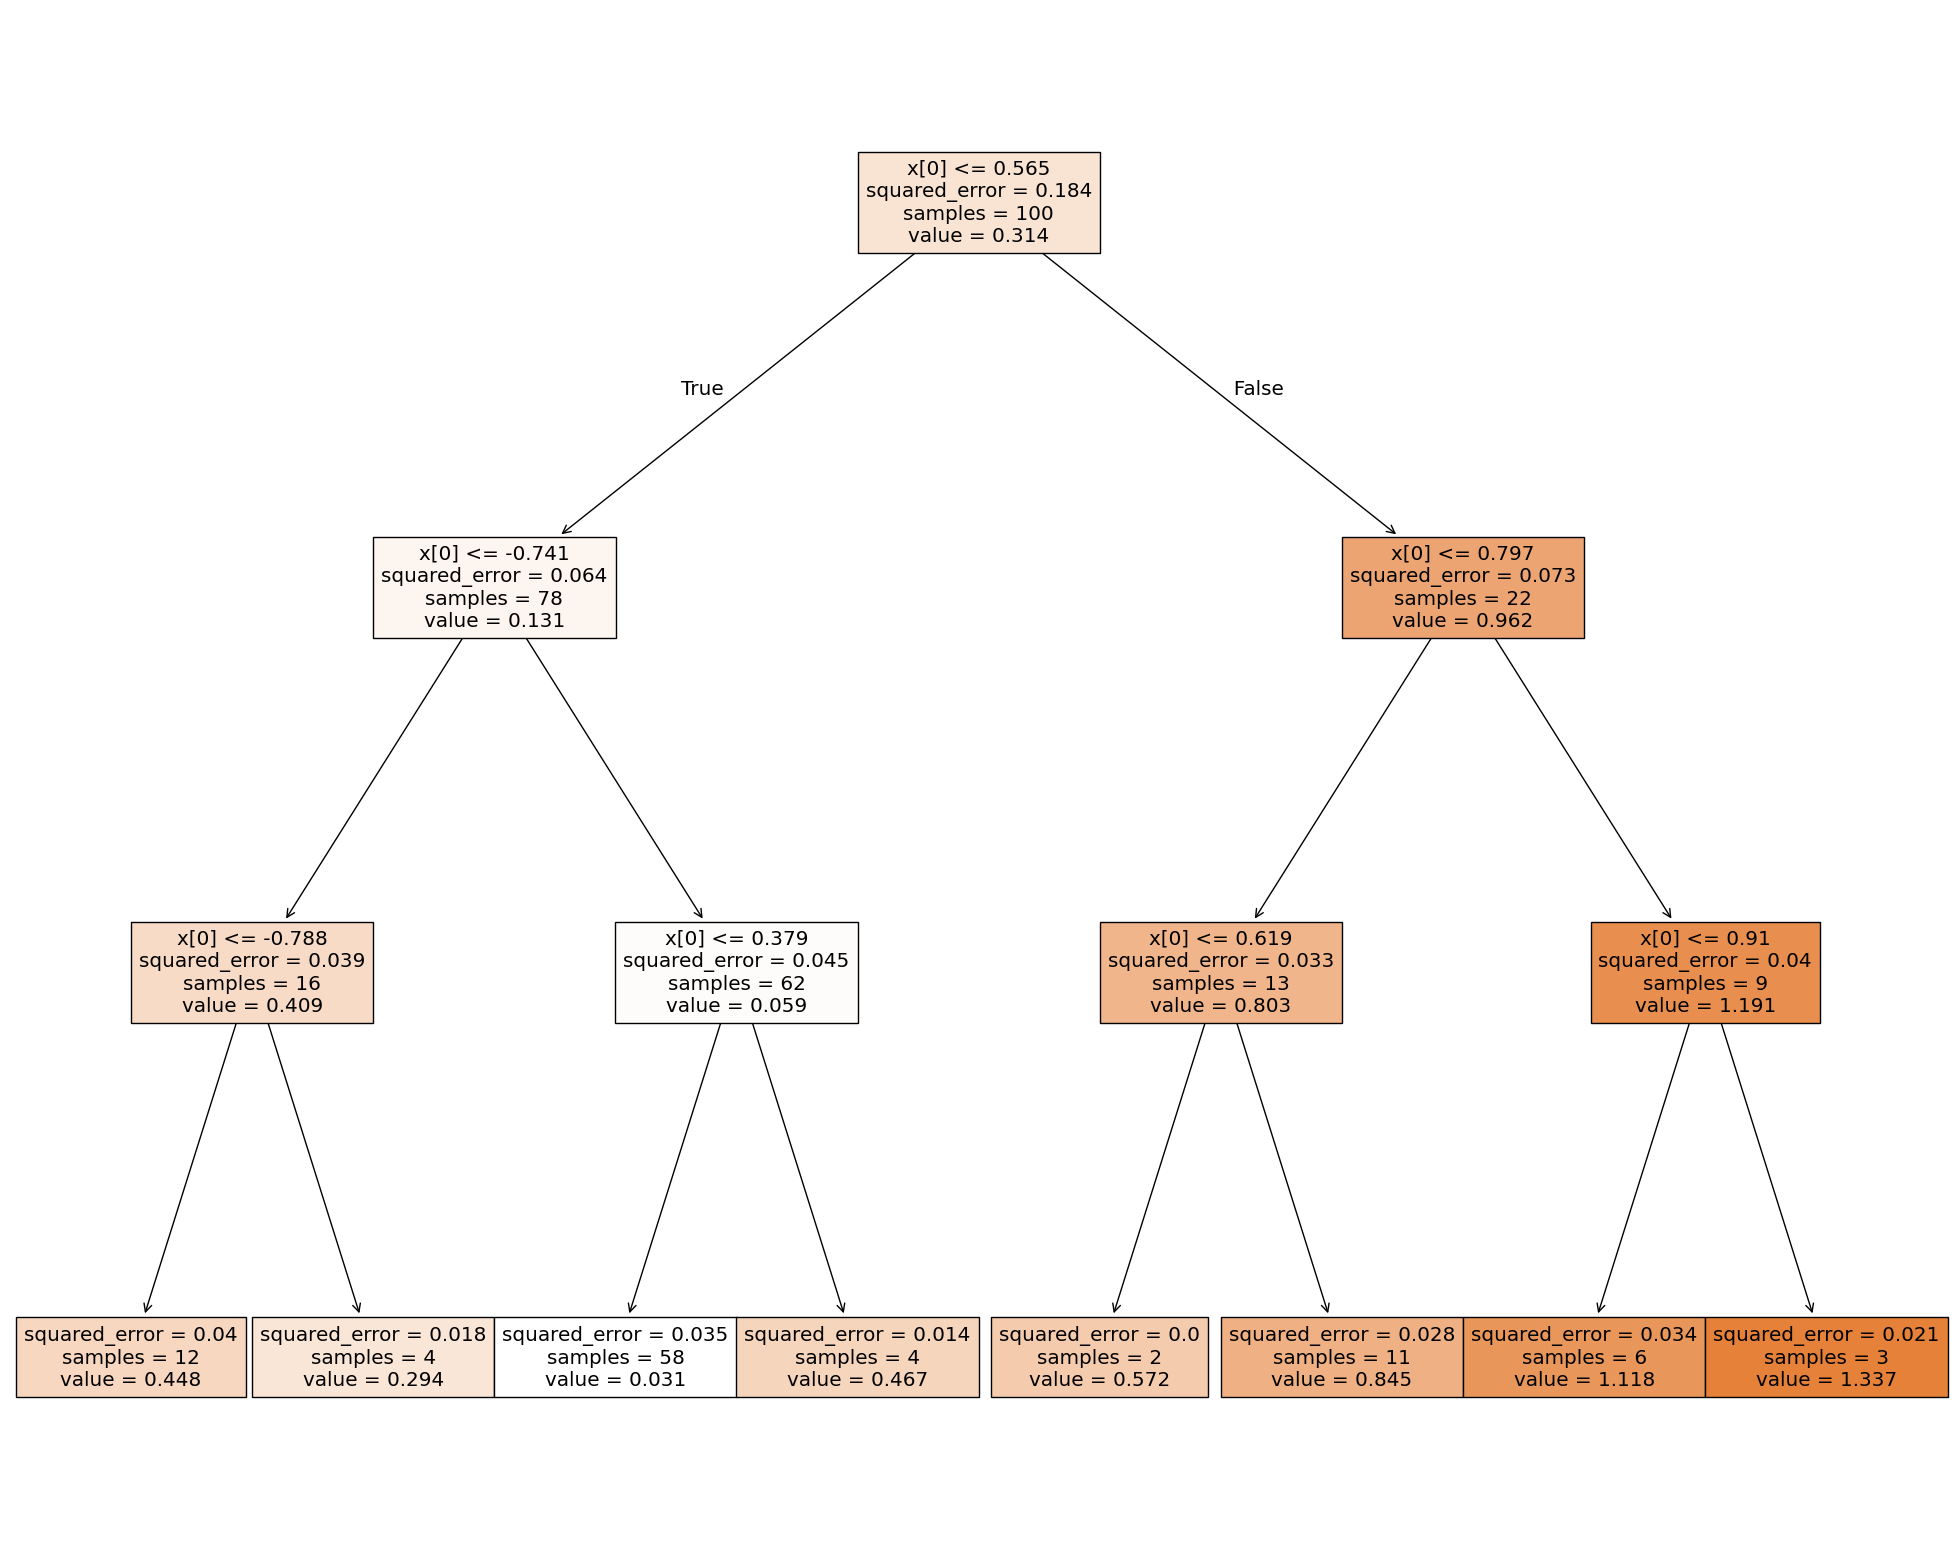

In [16]:
print(export_text(dt_reg2))
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_reg2, filled=True)

Na koniec tej części, warto wspomnieć o paru istotnych informacjach dotyczących drzew decyzyjnych.

1) Drzewa decyzyjne nie wymagają wcześniejszej standaryzacji danych - co więcej, ewentualna standaryzacja nie wpływa na wyniki oraz predykcję.

2) Drzewa decyzyjne mają skłonność do przeuczania się.

3) Pracując z drzewami, należy uważać przy detekcji outlierów - jeśli wykluczymy outliery ze zbioru treningowego, a analogiczne znajdą się w zbiorze testowym lub walidacyjnym, drzewo może takich wartości nie obsłużyć i zwrócić mocno niepoprawne predykcje.

4) W praktyce, drzewa decyzyjne wykorzystuje się głównie jako algorytm pomocniczy w algorytmach ensemble, takich jak na przykład Random Forest, LightGBM czy XGBoost.
***

## Ensemble Learning

Zdarza się, że predykcja z jednego modelu to za mało aby osiągnąć oczekiwane przez nas rezultaty. Może się okazać, że pojedynczy model ma skłonności do nadmiernego przeuczenia na zbiorze treningowym. W takim przypadku pojawia się potrzeba skorzystania z technik uczenia zespołowego **ensemble learning**. Jej celem jest zwiększenie skuteczności modelu oraz zmniejszenie wariancji błędów modelu poprzez wykorzystanie wielu modeli wyuczonych na danych treningowych. Podstawową koncepcją stojąca za **ensemble learning** jest łącznie wyników różnych modeli w celu stworzenia bardziej precyzyjnej prognozy np. poprzez uśrednienia wyników lub wybór najpopularnieszej predykcji ze wszystkich modeli. Takie podejście nie tylko zwiększa skuteczność modelu, ale ponadto zapewnia odporność systemu na anomalie pojawiające się w danych.

Podstawowymi technikami uczenia zespołowego są:
- Bagging
- Boosting

### Bagging

Technika uczenia zespołowego składająca się z dwóch części:
- Bootstrapp
- Agregacja

*Bootstrapping* polega na wybraniu losowej próbki danych ze zwracaniem. Na poniższym rysunku wybieramy próby bootstrapowe tj. d1, d2, ... d5. Odpowiednie dane trafiają do pojedynczego modelu tzw. *base learner*. Następnie następuje uczenie każdego z modeli *base learner*. Ostatecznie na każdym z modeli wywołujemy predykcję, które na końcu są agregowane. Celem jest zwiększenie skuteczności przy jednoczesnym zmniejszeniu wariancji. 

Przykładem algorytmu opartego o Bagging jest Random Forest, gdzie predykcje z drzew decyzyjnych (*base learners*) jest wykonywana jednocześnie a następnie agregowana przy pomocy średniej (dla problemów regresyjnych) lub mody (dla problemów klasyfikacyjnych). 

<!-- <img src="media/bagging_img.png" width=500 height=250 /> 
 -->
![media](media/bagging_img.png)

*Źródło: https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/*

### Boosting

Technika uczenia zespołowego polegająca na tym, że każdy model uczy się na błędach z poprzedniego modelu, tak aby tworzyć lepsze przewidywania w przyszłości. Jak widać na poniższym rysunku technika opiera się na sekwencyjnej nauce modelu tzw. *weak learner*, które w każdej iteracji stają się co raz lepsze. Ostatecznie celem jest stworzenie jednego modelu *strong learner*, który będzie charakteryzował się znaczną poprawą skuteczności.  

Przykładem algorytmu opartego o Boosting jest Gradient Boosting, XGBoost oraz LightGBM. Każdy z algorytmów opiera się na istnieniu *weak learners* oraz doskonaleniu się w kolejnych iteracjach algorytmu. W celu dokładnieszego zrozumienia działania podstawowego algorytmu Gradient Boositng zachęcam do lektury artykułu [Demonstrating the Potential of Gradient Boosting](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/).

<!-- <img src="media/boosting_img.png" width=500 height=250 /> 
 -->
![media](media/boosting_img.png)

*Źródło: https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/*

## Random Forest

Jak wspomniano wyżej, lasy losowe, bardziej znane pod nazwą random forest, są algorytmem ensemble, czyli wykorzystującym wiele modeli (algorytmów) jednocześnie. W przypadku lasów są to, jak sama nazwa wskazuje, drzewa decyzyjne. Konkretnie, ten algorytm tworzy $n$ drzew decyzyjnych, a następnie (w regresji) dla ustalonego rekordu ze zbioru testowego/walidacyjnego, zwraca średnią predykcję z tych drzew jako swoją predykcję dla owego rekordu.

**Konstrukcja**

Oczywiście, aby tworzenie wielu drzew decyzyjnych miało w ogóle sens, nie mogą być one identyczne. Taki efekt uzyskuje się łącząc dwie metody związane z losowaniem. Pierwszą z nich jest bagging, czyli bootstrap aggregating. Ten algorytm polega na tworzeniu nowego zbioru danych przez losowanie rekordów ze zbioru treningowego ze zwracaniem. Dzięki temu, każde drzewo z dużym prawdopodobieństwem będzie wytrenowane na innym zbiorze danych. Drugim elementem baggingu jest agregacja, czyli opisane wcześniej uśrednienie predykcji modeli pomocniczych.

Poza losowaniem danych treningowych dla każdego podmodelu, same drzewa również zawierają w sobie element losowości. Mianowicie, optymalny warunek dla każdego węzła jest determinowany jedynie na podstawie losowego podzbioru zmiennych objaśniających. Taka konstrukcja lasów redukuje skłonność podedynczego drzewa do przeuczania się. Nie ma ona jednak wpływu na problem drzew decyzyjnych z outlierami, a także nie zmienia tego, że standaryzacja nie zmienia wyników algorytmu.

**Hiperparametry**

Przykładowe hiperparametry lasów losowych:

- criterion - kryterium wyboru podziału węzła - jak w drzewach decyzyjnych,
- min_samples_split - minimalna liczba wartości do podzielenia węzła - jak w drzewach decyzyjnych,
- min_samples_leaf - minimalna liczba wartości w liściu drzewa - jak w drzewach decyzyjnych,
- max_depth - maksymalna głębokość drzewa - jak w drzewach decyzyjnych,


- max_features - liczba cech do rozpatrzenia w wyborze podziału każdego węzła,
- max_samples - liczba rekordów każdego losowego podzbioru do treningu drzew,
- n_estimators - liczba drzew w lesie.

Teraz zamodelujemy nasze dane lasem losowym.

In [17]:
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train,np.reshape(y_train, (100,)))
rf_preds = rf_reg.predict(x_valid)

In [18]:
wyniki8 = pd.DataFrame(data = {'RSS':[np.sum(np.square(preds_poly - y_valid)),
                                      np.sum(np.square(np.reshape(preds_dt2, (25,1)) - y_valid)),
                                      np.sum(np.square(np.reshape(rf_preds, (25,1)) - y_valid)),
                                    ],
                             'R2': [r2_score(y_valid, preds_poly),
                                    r2_score(y_valid, preds_dt2),
                                    r2_score(y_valid, rf_preds),
                                    ],
                             'MAE': [mean_absolute_error(y_valid, preds_poly), 
                                     mean_absolute_error(y_valid, preds_dt2),
                                     mean_absolute_error(y_valid, rf_preds),
                                    ]}, 
                      index=['square_reg', 'dt_reg', 'rf_reg']).style.background_gradient(cmap='Blues')
wyniki8

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,0.574310,0.853621,0.126859
rf_reg,0.982969,0.749462,0.150648


Domyślne wyniki znowu są słabe, więc znowu spróbujemy dostosować hiperparametr max_depth.

In [19]:
rf_reg2 = RandomForestRegressor(max_depth = 3)
rf_reg2.fit(x_train,np.reshape(y_train, (100,)))
rf_preds2 = rf_reg2.predict(x_valid)

In [20]:
wyniki9 = pd.DataFrame(data = {'RSS':[np.sum(np.square(preds_poly - y_valid)),
                                      np.sum(np.square(np.reshape(preds_dt2, (25,1)) - y_valid)),
                                      np.sum(np.square(np.reshape(rf_preds2, (25,1)) - y_valid)),
                                    ],
                             'R2': [r2_score(y_valid, preds_poly),
                                    r2_score(y_valid, preds_dt2),
                                    r2_score(y_valid, rf_preds2),
                                    ],
                             'MAE': [mean_absolute_error(y_valid, preds_poly), 
                                     mean_absolute_error(y_valid, preds_dt2),
                                     mean_absolute_error(y_valid, rf_preds2),
                                    ]}, 
                      index=['square_reg', 'dt_reg', 'rf_reg']).style.background_gradient(cmap='Blues')
wyniki9

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,0.574310,0.853621,0.126859
rf_reg,0.490039,0.875099,0.111054


W efekcie uzyskaliśmy najlepszy z trzech modeli.
***

## XGBoost

Extreme Gradient Boosting (XGBoost) jest zrównolegloną oraz starannie zoptymalizowaną wersją algorytmu Gradient Boosting. Proces zrównoleglenia całego procesu znacznie poprawia czas treningu. 

**Podstawowe cechy algorytmu**

- **Regularyzacja:** XGBoost posiada możliwość dodania kary L1 oraz L2 do procesu uczenia. Regularyzacja pomaga w uniknąć zjawiska przeuczenia modelu. 
- **Obsługa zmiennych kategorycznych oraz braków danych**: XGBoosty posiada wbudowaną metodę o nazwie "Sparsity-aware Split Finding", która procesuje zmienne kategoryczne. Dzięki temu w przypadku zmiennych, które uważamy za kategoryczne wystarczy zmienić ich typ danych na "category", a XGBoost sam zajmie się kwestią encodingu. Więcej informacji o algorytmu pod linkiem [Sparsity-aware Split Finding](https://medium.com/hypatai/how-xgboost-handles-sparsities-arising-from-of-missing-data-with-an-example-90ce8e4ba9ca). Podobnie jak z danymi kategorycznymi XGBoost obsługuje również braki danych. Algorytm przy podejmowaniu decyzji na rozgałęzieniu drzewa dostaje informacje, że dla danej obserwacji jest "brak danych" co determinuje brak możliwości odpowiedzenia na zadane pytanie, a to z kolei najczęściej sugeruje odpowiedź _False_. Na przykład gdy mamy rozgałęzienie i pytamy czy metraż mieszkania jest większy niż 50 $m^{2}$ to gdy nie mamy informacji o metrażu dla jednej z obserwacji to trafi ona do rozgałęzienia _False_ razem z tymi obserwacjami, których metraż jest mniejszy niż 50 $m^{2}$.
- **Weighted quantile sketch**: Jest to algorytm, który przybliża rozkład wartości cech, co pozwala na szybką identyfikację potencjalnych punktów podziału dla drzew decyzyjnych bez konieczności sortowania całego zestawu danych. Większość modeli drzewiastych znajduję punkt podziału gdy punkty danych mają takie same wagi (quantile sketch algorithm). XGBoost dodatkowo efektywnie wspiera ważenie danych (weighted quantile sketch algorithm). Dokładny opis obu metod znajdziemy pod linkiem [Weighted quantile sketch](https://medium.com/@wjj1019/in-depth-overview-of-xgboost-partii-45384b90d818)
- **Block structure for parallel learning**: XGBoost organizuje dane w sortowane, przechowywane w pamięci bloki kolumn, gdzie każdy blok odpowiada podzbiorowi cech. Dzięki niezależnemu przetwarzaniu bloków kolumn wiele rdzeni procesora węzłów obliczeniowych może jednocześnie pracować nad procesem budowania drzewa.
- **Cache awareness**: XGBoost organizuje swoje struktury danych i obliczenia, tak aby często używane elementy były obecne w pamięci podręcznej.
- **Early stopping**: XGBoost daje możliwość dodania kryteriów zatrzymania treningu modelu w przypadku, gdy kolejne iteracje nie dają znaczącego postępu.

**Sposób działania**

XGBoost podobnie jak Random Forest bazuje na drzewach decyzyjnych, jednak działa nieco inaczej. Mianowicie:
- na początku generuje wyjściową predykcję (w przypadku regresji jest to z reguły średnia wartość zmiennej objaśnianej z całego zbioru treningowego), 
- następnie tworzy drzewo decyzyjne na resztach z tej predykcji, wyliczając tym samym oczekiwany błąd,
- zmniejsza ów błąd mnożąc go przez liczbę z przedziału $(0,1)$, 
- ostatecznie dodaje pomniejszony błąd do predykcji wyjściowej, tworząc nową predykcję. 

Jest to proces iteracyjny, potwarzany $n$ razy. Opisany tu algorytm nosi nazwę Gradient Boosting, zaś XGBoost jest jego implementacją, która wyróżnia się przede wszystkim metodą konstruowania kolejnych drzew decyzyjnych **Level-wise tree growth** tj. poziom po poziomie.

Dokładnieszy opis działania algorytmu (również matematycznie) znajdziemy pod linkiem [What is XGBoost Algorithm?](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost)

<!-- <img src="media/xgboost_img.png" width=700 height=400 />
 -->
![media](media/xgboost_img.png)


*Źródło: https://neptune.ai/blog/xgboost-vs-lightgbm*

**Hiperparametry**

Podstawowymi hiperparametrami modelu są:
- *learning_rate / eta* - wielkość kroku przy aktualizacji wag. Im większa wartość tym kroki algorytmu są większe podczas poszukiwania minimum globalnego funkcji. Oznacza to, że możemy przeskoczyć minimum i go nie znaleźć. Z kolei zbyt mała wartość parametru może spowodować długi proces uczenia oraz utknięcnie w lokalnym minimum - wielkość kroku na tyle mała, że nie możemy wyjść z lokalnego minimum.
- *gamma* - minimalna wartość redukcji straty wymagana do wykonania dalszego podziału na węźle liściowym drzewa. Im większa wartość, tym model jest bardziej konserwatywny,
- *max_depth* - maksymalna głębokość drzewa. Im większa wartość tym model bardziej złożony oraz narażony na przeuczenie.
- *min_child_weight* - minimalna suma ważona liczba obserwacji w każdym liściu drzewa. Im więsza wartość, tym model jest bardziej konserwatywny, 

Dodatkowo w celu ograniczenia przeuczania modelu stosujemy:
- *subsample* - podpróbkowanie danych treningowych. Ustawienie na wartość 0.5 oznacza, że przed wyhodowaniem drzewa model najpierw wylosuje połowę danych treningowych. Podpróbkowanie będzie miało miejsce w każdej iteracji wzmacniającej. Ustawnienie parametru poniżej 1 ma na celu zapobieganie nadmiernemu dopasowaniu modelu,
- *colsample_bytree* - jest współczynnikiem podpróbek kolmun, który chcemy losować podczas konstruowania każdego drzewa. Podpróbkowania odbywa się raz dla każdego konstruowanego drzewa.
- *colsample_bylevel* - jest współczynnikiem podpróbek kolmun, który chcemy losować po każdym kolejnym podziale danych.
- *colsample_bynode* - jest współczynnikiem podpróbek kolmun, który chcemy losować podczas każdego rozgałęzienia w drzewie.
- *max_delta_step* - maksymalny krok delta pozwalający na wyjście z każdego liścia. Wartość 0 oznacza brak ograniczeń.
- *alpha* - regularyzacja L1 przyjmująca wartości od 0 do nieskończoności. Im większa wartość, tym model bardziej konserwtywny.
- *lambda* - regularyzacja L2 przyjmująca wartości od 0 do nieskończoności. Im większa wartość, tym model bardziej konserwatywny.



### Różnice pomiędzy Random Forest vs XGBoost

| Feature    | XGBoost | Random Forest |
| -------- | ------- | ------- |
| Opis  | Poprawia błędy z poprzednich drzew | Buduję drzewa niezależnie |
| Typ algorytmu | Boosting | Bagging |
| Postępowanie z _Weak Learners_  | Koryguje błędy sekwencyjnie | Agreguje prognozy oparte na niezależnie wyuczonych drzewach |
| Regularyzacja | Wspiera normę L1 oraz L2| Zazwyczaj nie wspiera regularyzacji modelu|
| Skuteczność | Zazwyczaj działa lepiej na danych ustrukturyzowanych, ale wymaga hiperparametryzacji | Prostszy i mniej podatny na nadmierne dopasowanie |

### Przykład

Poniżej analogiczny przykład jak w poprzednich algorytmach. Sprawdźmy skuteczność XGBoost z domyślnymi parametrami. 

In [21]:
xgboost_model = xgboost.XGBRegressor()
xgboost_model.fit(x_train, np.reshape(y_train, (100,)))
preds_xgboost = xgboost_model.predict(x_valid)

In [22]:
wyniki_xgboost = pd.DataFrame(
    data = 
        {
            'RSS':[np.sum(np.square(preds_poly - y_valid)),
                  np.sum(np.square(np.reshape(preds_dt2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(rf_preds2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(preds_xgboost, (25,1)) - y_valid))
                ],
            'R2': [r2_score(y_valid, preds_poly),
                r2_score(y_valid, preds_dt2),
                r2_score(y_valid, rf_preds2),
                r2_score(y_valid, preds_xgboost)
                ],
            'MAE': [mean_absolute_error(y_valid, preds_poly), 
                 mean_absolute_error(y_valid, preds_dt2),
                 mean_absolute_error(y_valid, rf_preds2),
                 mean_absolute_error(y_valid, preds_xgboost)]
        }, 
    index=['square_reg', 'dt_reg', 'rf_reg', 'xgboost_reg']
).style.background_gradient(cmap='Blues')
wyniki_xgboost

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,0.574310,0.853621,0.126859
rf_reg,0.490039,0.875099,0.111054
xgboost_reg,1.479689,0.622859,0.200948


Okazuje się, że z domyślnymi hiperparametrami model jest nawet gorszy od regresji wielomianowej. Co jeśli pobawimy się hiperparametrami ?

In [23]:
xgboost_model2 = xgboost.XGBRegressor(max_depth=1, gamma=0.1)
xgboost_model2.fit(x_train,np.reshape(y_train, (100,)))
preds_xgboost2 = xgboost_model2.predict(x_valid)

In [24]:
wyniki_xgboost = pd.DataFrame(
    data = 
        {
            'RSS':[np.sum(np.square(preds_poly - y_valid)),
                  np.sum(np.square(np.reshape(preds_dt2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(rf_preds2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(preds_xgboost2, (25,1)) - y_valid))
                ],
            'R2': [r2_score(y_valid, preds_poly),
                r2_score(y_valid, preds_dt2),
                r2_score(y_valid, rf_preds2),
                r2_score(y_valid, preds_xgboost2)
                ],
            'MAE': [mean_absolute_error(y_valid, preds_poly), 
                 mean_absolute_error(y_valid, preds_dt2),
                 mean_absolute_error(y_valid, rf_preds2),
                 mean_absolute_error(y_valid, preds_xgboost2)]
        }, 
    index=['square_reg', 'dt_reg', 'rf_reg', 'xgboost_reg']
).style.background_gradient(cmap='Blues')
wyniki_xgboost

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,0.574310,0.853621,0.126859
rf_reg,0.490039,0.875099,0.111054
xgboost_reg,0.564405,0.856145,0.118005


Teraz wygląda to znacznie lepiej. Zauważy jednak, że model jest wciąż gorszy od Random Forest, a nawet wyniki są podobne do Decision Trees. Wynika to głównie z charakterystyki powyższej ramki danych. Jest ona mała, a dodatkowo ma bardzo mało danych. Zobaczymy jak to będzie wyglądać dla nieco większego zbioru ?

Najpierw tworzymy losowy zbiór danych. Wykorzystamy do tego funkcje ```make_regression``` pakietu ```sklearn```.

In [25]:
from sklearn.datasets import make_regression

# Data
X, y = make_regression(n_samples=10000, n_features=10, noise=2, random_state=42)

# Train test split
x_train_mr, x_valid_mr, y_train_mr, y_valid_mr = train_test_split(X, y, random_state = 11, test_size = 0.2)

Następnie wytrenujemy 3 modele: DecistionTree, RandomForest oraz XGBoost. Porównajmy ich skuteczności oraz czas kalkulacji.

In [26]:
%%time
# Decision Trees
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(x_train_mr, np.reshape(y_train_mr, (len(y_train_mr),)))
preds_dt_model = decision_tree_model.predict(x_valid_mr)

CPU times: total: 46.9 ms
Wall time: 86.9 ms


In [27]:
%%time
# Random Forest
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train_mr, np.reshape(y_train_mr, (len(y_train_mr),)))
preds_rf_model = random_forest_model.predict(x_valid_mr)

CPU times: total: 2.23 s
Wall time: 5.88 s


In [28]:
%%time
# XGBoost
xgboost_model = xgboost.XGBRegressor()
xgboost_model.fit(x_train_mr, np.reshape(y_train_mr, (len(y_train_mr),)))
preds_xgboost_model = xgboost_model.predict(x_valid_mr)

CPU times: total: 1.59 s
Wall time: 104 ms


In [29]:
wyniki_xgboost = pd.DataFrame(
    data = 
        {
            'RSS':[
                  np.sum(np.square(np.reshape(preds_dt_model, (len(y_valid_mr), 1)) - y_valid_mr)),
                  np.sum(np.square(np.reshape(preds_rf_model, (len(y_valid_mr), 1)) - y_valid_mr)),
                  np.sum(np.square(np.reshape(preds_xgboost_model, (len(y_valid_mr), 1)) - y_valid_mr))
                ],
            'R2': [
                r2_score(y_valid_mr, preds_dt_model),
                r2_score(y_valid_mr, preds_rf_model),
                r2_score(y_valid_mr, preds_xgboost_model)
                ],
            'MAE': [
                 mean_absolute_error(y_valid_mr, preds_dt_model),
                 mean_absolute_error(y_valid_mr, preds_rf_model),
                 mean_absolute_error(y_valid_mr, preds_xgboost_model)]
        }, 
    index=['dt_reg', 'rf_reg', 'xgboost_reg']
).style.background_gradient(cmap='Blues')
wyniki_xgboost

,RSS,R2,MAE
dt_reg,204050950398.135620,0.758806,62.622685
rf_reg,182549366086.138123,0.921081,34.902868
xgboost_reg,202746427572.298492,0.963205,24.125312


Okazuje się, że już dla nieco większej próbki danych (ok.8 tys. rekordów w danych treningowych) oraz dla większej liczby zmiennych model XGBoost działa szybciej od RandomForest oraz osiąga lepsze metryki skuteczności. DecisionTree dla takiej ramki danych ma skuteczność dużo mniejszą.

## LightGBM

LightGBM jest bardzo podobnym algorytmem do XGBoost, czyli również korzysta z Gradient Boostingu. 

**Podstawowe cechy algorytmu**

- **Szybszy trening oraz większa efektywność**: LightGBM wykorzystuje _Histogram based algorithm_, tj. grupuje ciągłe wartości cech do dyskretnych przedziałów, co przyspiesza procedurę treningową. Więcej informacji na ten temat pod linkiem [Histogram based algorithm](https://www.geeksforgeeks.org/lightgbm-histogram-based-learning/)
- **Mniejsze wykorzystanie pamięci**: Zastępuje wartości ciągłe wartościami dyskretnymi, co skutkuje mniejszym wykorzystaniem pamięci.
- **Większa skuteczność niż jakikolwiek inny model boosting'owy**: LightGBM tworzy bardziej złożone drzewa z uwagi na podejście _Leaf-wise tree growth_. Jest to podstawowa przyczyna większej skuteczności modelu w stosunku do innych algorytmów. Jednakże, czsami prowadzi to do nadmiernego dopasowania co można unikąć dopasowuąc parametr _max_depth_.
- **Kompatybilność z dużymi ramkami danych**: W porównaniu do XGBoost równie dobrze radzi sobie z dużymi zbiorami danych, przy znacznie krótszym czasie treningu.
- **Wsparcie zrównoleglonych obliczeń**

**Sposób działania**

LigthGBM różni się od XGBoost sposobem konstruowania pomocniczych drzew decyzyjnych - tutaj każdy nowy węzeł jest zawsze tym najlepszym w danym momencie, niezależnie od poziomu głębokości drzewa tego węzła (_Leaf-wise tree growth_). Poza tym te algorytmy nieco inaczej obsługują zmienne kategoryczne. LightGBM jest też dużo lżejszym algorytmem, co zresztą narzuca sama nazwa - jest szybszy w działaniu i wymaga mniej pamięci, a mimo to daje bardzo zbliżone rezultaty - w dokumentacji można nawet przeczytać, że lepsze :)

<!-- <img src="media/lightgbm_img.png" width=700 height=400 /> 
 -->
![media](media/lightgbm_img.png)

*Źródło: https://neptune.ai/blog/xgboost-vs-lightgbm*

Dokładniejszy opis działania można znaleźć pod linkiem [LightGBM: A Highly Efficient Gradient Boosting
Decision Tree](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf).

**Hiperparametry**

- *max_depth* - maksymalna głębokość drzewa. Im większa wartość tym model bardziej złożony oraz narażony na przeuczenie.
- *num_leaves* – jest to bardzo ważny parametr pod kątem kontrolowania złożoności budowanego drzewa. Wartość powinna być mniejsza niż $2^{max\_depth}$ jako, że _Leaf-wise tree_ jest znacznie głębsze niż _Level-wise tree_ dla określonej grupy liści. Zbyt wysoka wartość parametru może spowodować nadmierne dopasowanie.
- *min_data_in_leaf* - parametru służący do kontrolowania nadmiernego dopasowania. Wysoka wartość zatrzymuje rozrost drzewa, ale może również spowodować zbyt małe dopasowanie modelu. Zgodnie z dokumentacja zalecia się, aby wartość parametru była w setkach lub tysiącach.
- *feature_fraction* - jest współczynnikiem podpróbek kolmun, który chcemy losować podczas konstruowania każdego drzewa. Podpróbkowania odbywa się raz dla każdego konstruowanego drzew, podobnie jak _colsample_bytree_ w XGBoost.
- *bagging_fraction* - podpróbkowanie danych treningowych. Ustawienie na wartość 0.5 oznacza, że przed wyhodowaniem drzewa model najpierw wylosuje połowę danych treningowych. Podpróbkowanie będzie miało miejsce w każdej iteracji wzmacniającej. Ustawnienie parametru poniżej 1 ma na celu zapobieganie nadmiernemu dopasowaniu modelu. Podobnie jak _subsample_ w XGBoost.
- *max_bin* - mniejsza wartość parametru przyspiesza czas treningu, ponieważ podczas nauki dane dzielone są na podpróbki i im jest ich mniej tym czas również się zmniejsza. Generalnie zwiększenie tego parametru ma podobny efekt jak zwiększenie parametru _num_leaves_ ponieważ im więcej podpróbek tym bardziej szczegółowe drzewa podobnie, jak przy zwiększenieu _num_leaves_. 

### Różnice pomiędzy XGBoost vs LightGBM

| Feature    | LightGBM |XGBoost |
| -------- | ------- | ------- |
| Opis  | Poprawia błędy z poprzednich drzew | Poprawia błędy z poprzednich drzew |
| Typ algorytmu | Boosting | Boosting |
| Podział głębokości drzewa | Leaf-wise | Level-wise | 
| Interpretowalność | Zawzwyczaj drzewa są bardziej złożone z uwagi na typ podziału drzewa | Łatwiejsze w interpretacji niż LightGBM |
| Skuteczność | Zazwyczaj jest bardziej skuteczny, ale może pojawić się problem z nadmiernym dopasowaniem | Zazwyczaj osiąga bardzo dobre wyniki |
| Szybkość | Działa szybciej z uwagi na inny typ podziału drzewa | Jest wolnieszy, widać to zwłaszcza na dużych ramkach danych |

### Przykład

In [30]:
lgbm_model = lightgbm.LGBMRegressor()
lgbm_model.fit(x_train, np.reshape(y_train, (100,)))
preds_lgbm = lgbm_model.predict(x_valid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 1
[LightGBM] [Info] Start training from score 0.313750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [31]:
wyniki_lgbm = pd.DataFrame(
    data = 
        {
            'RSS':[np.sum(np.square(preds_poly - y_valid)),
                  np.sum(np.square(np.reshape(preds_dt2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(rf_preds2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(preds_xgboost, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(preds_lgbm, (25,1)) - y_valid)) 
                ],
            'R2': [r2_score(y_valid, preds_poly),
                r2_score(y_valid, preds_dt2),
                r2_score(y_valid, rf_preds2),
                r2_score(y_valid, preds_xgboost),
                r2_score(y_valid, preds_lgbm)
                ],
            'MAE': [mean_absolute_error(y_valid, preds_poly), 
                 mean_absolute_error(y_valid, preds_dt2),
                 mean_absolute_error(y_valid, rf_preds2),
                 mean_absolute_error(y_valid, preds_xgboost),
                 mean_absolute_error(y_valid, preds_lgbm)
                ]
        }, 
    index=['square_reg', 'dt_reg', 'rf_reg', 'xgboost_reg', 'lgbm_reg']
).style.background_gradient(cmap='Blues')
wyniki_lgbm

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,0.574310,0.853621,0.126859
rf_reg,0.490039,0.875099,0.111054
xgboost_reg,1.479689,0.622859,0.200948
lgbm_reg,0.968005,0.753276,0.155268


Jak widać LightGBM z domyślnymi parametrami radzi sobię lepiej niż XGBoost, ale wciaż gorzej niż prostsze modele. W tym przypadku również spróbujmy pobawić się hiperparametrami.

In [32]:
lgbm_model2 = lightgbm.LGBMRegressor(max_depth=1, learning_rate=0.05)
lgbm_model2.fit(x_train, np.reshape(y_train, (100,)))
preds_lgbm2 = lgbm_model2.predict(x_valid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 1
[LightGBM] [Info] Start training from score 0.313750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [33]:
wyniki_lgbm = pd.DataFrame(
    data = 
        {
            'RSS':[np.sum(np.square(preds_poly - y_valid)),
                  np.sum(np.square(np.reshape(preds_dt2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(rf_preds2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(preds_xgboost2, (25,1)) - y_valid)),
                  np.sum(np.square(np.reshape(preds_lgbm2, (25,1)) - y_valid)) 
                ],
            'R2': [r2_score(y_valid, preds_poly),
                r2_score(y_valid, preds_dt2),
                r2_score(y_valid, rf_preds2),
                r2_score(y_valid, preds_xgboost2),
                r2_score(y_valid, preds_lgbm2)
                ],
            'MAE': [mean_absolute_error(y_valid, preds_poly), 
                 mean_absolute_error(y_valid, preds_dt2),
                 mean_absolute_error(y_valid, rf_preds2),
                 mean_absolute_error(y_valid, preds_xgboost2),
                 mean_absolute_error(y_valid, preds_lgbm2)
                ]
        }, 
    index=['square_reg', 'dt_reg', 'rf_reg', 'xgboost_reg', 'lgbm_reg']
).style.background_gradient(cmap='Blues')
wyniki_lgbm

,RSS,R2,MAE
square_reg,0.710297,0.818960,0.131138
dt_reg,0.574310,0.853621,0.126859
rf_reg,0.490039,0.875099,0.111054
xgboost_reg,0.564405,0.856145,0.118005
lgbm_reg,0.822966,0.790244,0.135914


Ostatecznie bardzo trudno jest uzyskać lepsze rezultaty niż powyższe na tej ramce danych. Spróbujmy powtórzyć poprzedni eksperyment i wykorzystajmy model LightGBM do treningu na bardziej złożonej ramce danych.

In [34]:
%%time
# LightGBM
lgbm_model = lightgbm.LGBMRegressor()
lgbm_model.fit(x_train_mr, np.reshape(y_train_mr, (len(y_train_mr),)))
preds_lgbm_model = lgbm_model.predict(x_valid_mr)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] Start training from score 0.511808
CPU times: total: 344 ms
Wall time: 82.1 ms


In [35]:
wyniki_lgbm = pd.DataFrame(
    data = 
        {
            'RSS':[
                  np.sum(np.square(np.reshape(preds_dt_model, (len(y_valid_mr), 1)) - y_valid_mr)),
                  np.sum(np.square(np.reshape(preds_rf_model, (len(y_valid_mr), 1)) - y_valid_mr)),
                  np.sum(np.square(np.reshape(preds_xgboost_model, (len(y_valid_mr), 1)) - y_valid_mr)),
                  np.sum(np.square(np.reshape(preds_lgbm_model, (len(y_valid_mr), 1)) - y_valid_mr))
                ],
            'R2': [
                r2_score(y_valid_mr, preds_dt_model),
                r2_score(y_valid_mr, preds_rf_model),
                r2_score(y_valid_mr, preds_xgboost_model),
                r2_score(y_valid_mr, preds_lgbm_model)
                ],
            'MAE': [
                 mean_absolute_error(y_valid_mr, preds_dt_model),
                 mean_absolute_error(y_valid_mr, preds_rf_model),
                 mean_absolute_error(y_valid_mr, preds_xgboost_model),
                 mean_absolute_error(y_valid_mr, preds_lgbm_model),
            ]
        }, 
    index=['dt_reg', 'rf_reg', 'xgboost_reg', 'lgbm_reg']
).style.background_gradient(cmap='Blues')
wyniki_lgbm

,RSS,R2,MAE
dt_reg,204050950398.135620,0.758806,62.622685
rf_reg,182549366086.138123,0.921081,34.902868
xgboost_reg,202746427572.298492,0.963205,24.125312
lgbm_reg,200089746001.024780,0.979257,17.614669


Jak widać model LightGBM działa ostatecznie jeszcze szybciej niż XGBoost, a dodatkowo jego skuteczność też jest wyższa.

Podsumowując mogłoby się wydawać, że modele LightGBM i XGBoost są najlepszymi wyborami podczas budowy modelu uczenia maszynowego. Bardzo często tak właśnie jest, ale wszystko zależy od złożoności problemu. Czasem może się zdarzyć, że mamy mało danych i wtedy lepiej wykorzystać model typu DecisionTree lub RandomForest do treningu modelu. Takie modele są dużo łatwiejsze w interpretacji niż algorytmy Boosting'owe. Ponadto w sytuacji, gdy różnica w skuteczności nie jest duża warto zastanowić się czy nie oprzeć systemu na nieco gorszym modelu, ale łatwiejszym do wdrożenia, utrzymania czy interpretacji. Na końcu wszystko zależy od wymagań zebranych podczas projektu.

## Bibliografia

- https://en.wikipedia.org/wiki/Polynomial_regression
- https://medium.com/analytics-vidhya/regression-trees-decision-tree-for-regression-machine-learning-e4d7525d8047
- https://xgboost.readthedocs.io/en/stable/
- https://lightgbm.readthedocs.io/en/v3.3.2/
- https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/
- https://neptune.ai/blog/xgboost-everything-you-need-to-know
- https://medium.com/@wjj1019/in-depth-overview-of-xgboost-partii-45384b90d818
- https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/
- https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf
- https://medium.com/@soyoungluna/simple-explanation-of-xgboost-without-complicated-mathematics-622c9c54c8a9
- https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/?utm_source=reading_list&utm_medium=https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/
- https://neptune.ai/blog/xgboost-vs-lightgbm